# Customer Analytics for a Telecom Provider

### Importing Libraries

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Load Dataset

In [4]:
df = pd.read_csv("dataset/telecom_customer_data.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,CUST00001,Male,0,Yes,No,54,No,No phone service,Fiber optic,No internet service,Yes,No internet service,Yes,No internet service,No internet service,Two year,Yes,Mailed check,96.48,No
1,CUST00002,Female,0,No,No,35,Yes,No,No,Yes,No,Yes,Yes,No,No internet service,One year,No,Credit card (automatic),87.58,No
2,CUST00003,Male,0,Yes,No,36,Yes,No phone service,No,No internet service,No internet service,No internet service,Yes,Yes,Yes,Month-to-month,No,Bank transfer (automatic),79.78,No
3,CUST00004,Male,0,No,Yes,13,No,No phone service,Fiber optic,No,Yes,No,No,No internet service,No internet service,One year,Yes,Bank transfer (automatic),112.28,Yes
4,CUST00005,Male,1,No,Yes,26,Yes,No,Fiber optic,No,Yes,No,No,No internet service,No internet service,Month-to-month,Yes,Mailed check,45.77,Yes


### Info about data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5000 non-null   object 
 1   gender            5000 non-null   object 
 2   SeniorCitizen     5000 non-null   int64  
 3   Partner           5000 non-null   object 
 4   Dependents        5000 non-null   object 
 5   tenure            5000 non-null   int64  
 6   PhoneService      5000 non-null   object 
 7   MultipleLines     5000 non-null   object 
 8   InternetService   5000 non-null   object 
 9   OnlineSecurity    5000 non-null   object 
 10  OnlineBackup      5000 non-null   object 
 11  DeviceProtection  5000 non-null   object 
 12  TechSupport       5000 non-null   object 
 13  StreamingTV       5000 non-null   object 
 14  StreamingMovies   5000 non-null   object 
 15  Contract          5000 non-null   object 
 16  PaperlessBilling  5000 non-null   object 


### Descriptive Statistics of data

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5000.0,0.498200,0.500047,0.0,0.0000,0.000,1.000,1.0
tenure,5000.0,35.828400,20.994340,0.0,17.7500,36.000,54.000,72.0
MonthlyCharges,5000.0,70.229976,27.907778,18.0,49.4375,70.185,90.895,120.0


In [7]:
df.describe(include=['object']).T

,count,unique,top,freq
customerID,5000,5000,CUST05000,1
gender,5000,2,Male,2504
Partner,5000,2,Yes,2508
Dependents,5000,2,No,2501
PhoneService,5000,2,No,2542
MultipleLines,5000,3,No phone service,1712
InternetService,5000,3,DSL,1782
OnlineSecurity,5000,3,No internet service,1740
OnlineBackup,5000,3,No,1690
DeviceProtection,5000,3,No,1755


In [8]:
df['Churn'].value_counts()

Churn
No     3652
Yes    1348
Name: count, dtype: int64

so, here data is imbalanced

In [9]:
df1 = df.copy()

### Finding Duplicates

In [10]:
df1.duplicated().any()

np.False_

So, here are no duplicate entries.

### Dropping unnecessary column

In [11]:
df1.drop('customerID', axis=1, inplace=True)

### Finding Missing Values

In [12]:
# checking missing values before removing whitespaces
df1.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
Churn               0
dtype: int64

In [13]:
# Remove leading/trailing whitespaces from all object columns.
# This helps detect hidden missing values like '   ' or 'NaN ' (with spaces), which are strings and not recognized as actual NaN by pandas.
for column in df1.select_dtypes(include=['object']).columns:
    df1[column] = df1[column].str.strip()

In [14]:
# checking missing values after removing whitespaces
df1.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
Churn               0
dtype: int64

So, Here no missing values present.

### Finding Outliers

#### Separating numerical columns and categorical columns

In [15]:
numerical_cols = ['tenure','MonthlyCharges','SeniorCitizen']
target_col = ['Churn']
categorical_cols = []
for col in df1.columns:
    if col not in numerical_cols and col not in target_col:
        categorical_cols.append(col)
print(categorical_cols)

['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


#### Finding outliers using boxplot in numerical columns

using plotly

In [16]:
fig = make_subplots(rows=1, cols=3, subplot_titles=numerical_cols)
for i, column in enumerate(numerical_cols):
    row = 1
    col = i + 1

    boxplot = px.box(df1, x=column)
    for trace in boxplot.data:
        fig.add_trace(trace, row=row, col=col)
fig.update_layout(height=500, width=1300, showlegend=False)

using seaborn

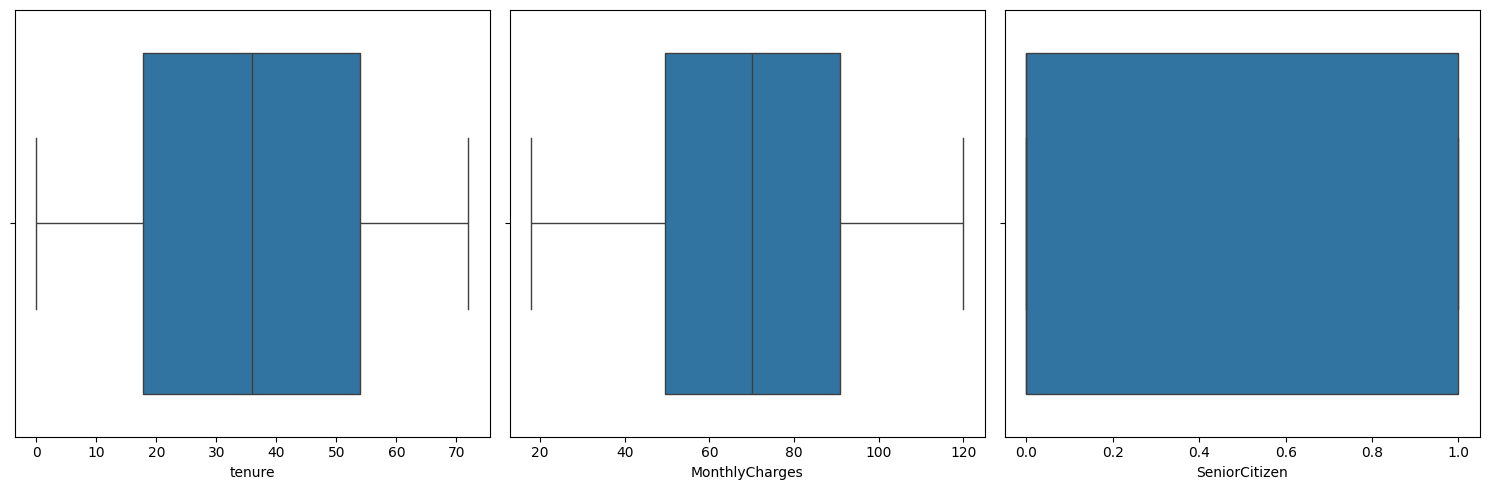

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, column in enumerate(numerical_cols):
    sns.boxplot(data=df1, x=column, ax=axes[i])
    
plt.tight_layout()
plt.show()

So, Here no outliers in numerical columns.

#### Value counts of Categorical columns to see imbalance data

using plotly

In [18]:
fig = make_subplots(rows=4, cols=4, subplot_titles=categorical_cols)
for i, column in enumerate(categorical_cols):
    row = i // 4 + 1
    col = i % 4 + 1

    value_counts = df1[column].value_counts().reset_index()
    value_counts.columns = ['Category', 'count']

    bar = go.Bar(
        x=value_counts['Category'],
        y=value_counts['count'],
        text=value_counts['count'],
        showlegend=True
    )
    fig.add_trace(bar, row=row, col=col)

fig.update_layout(height=1300, width=1200, title_text="Value Counts of Categorical Columns")
fig.show()


using seaborn

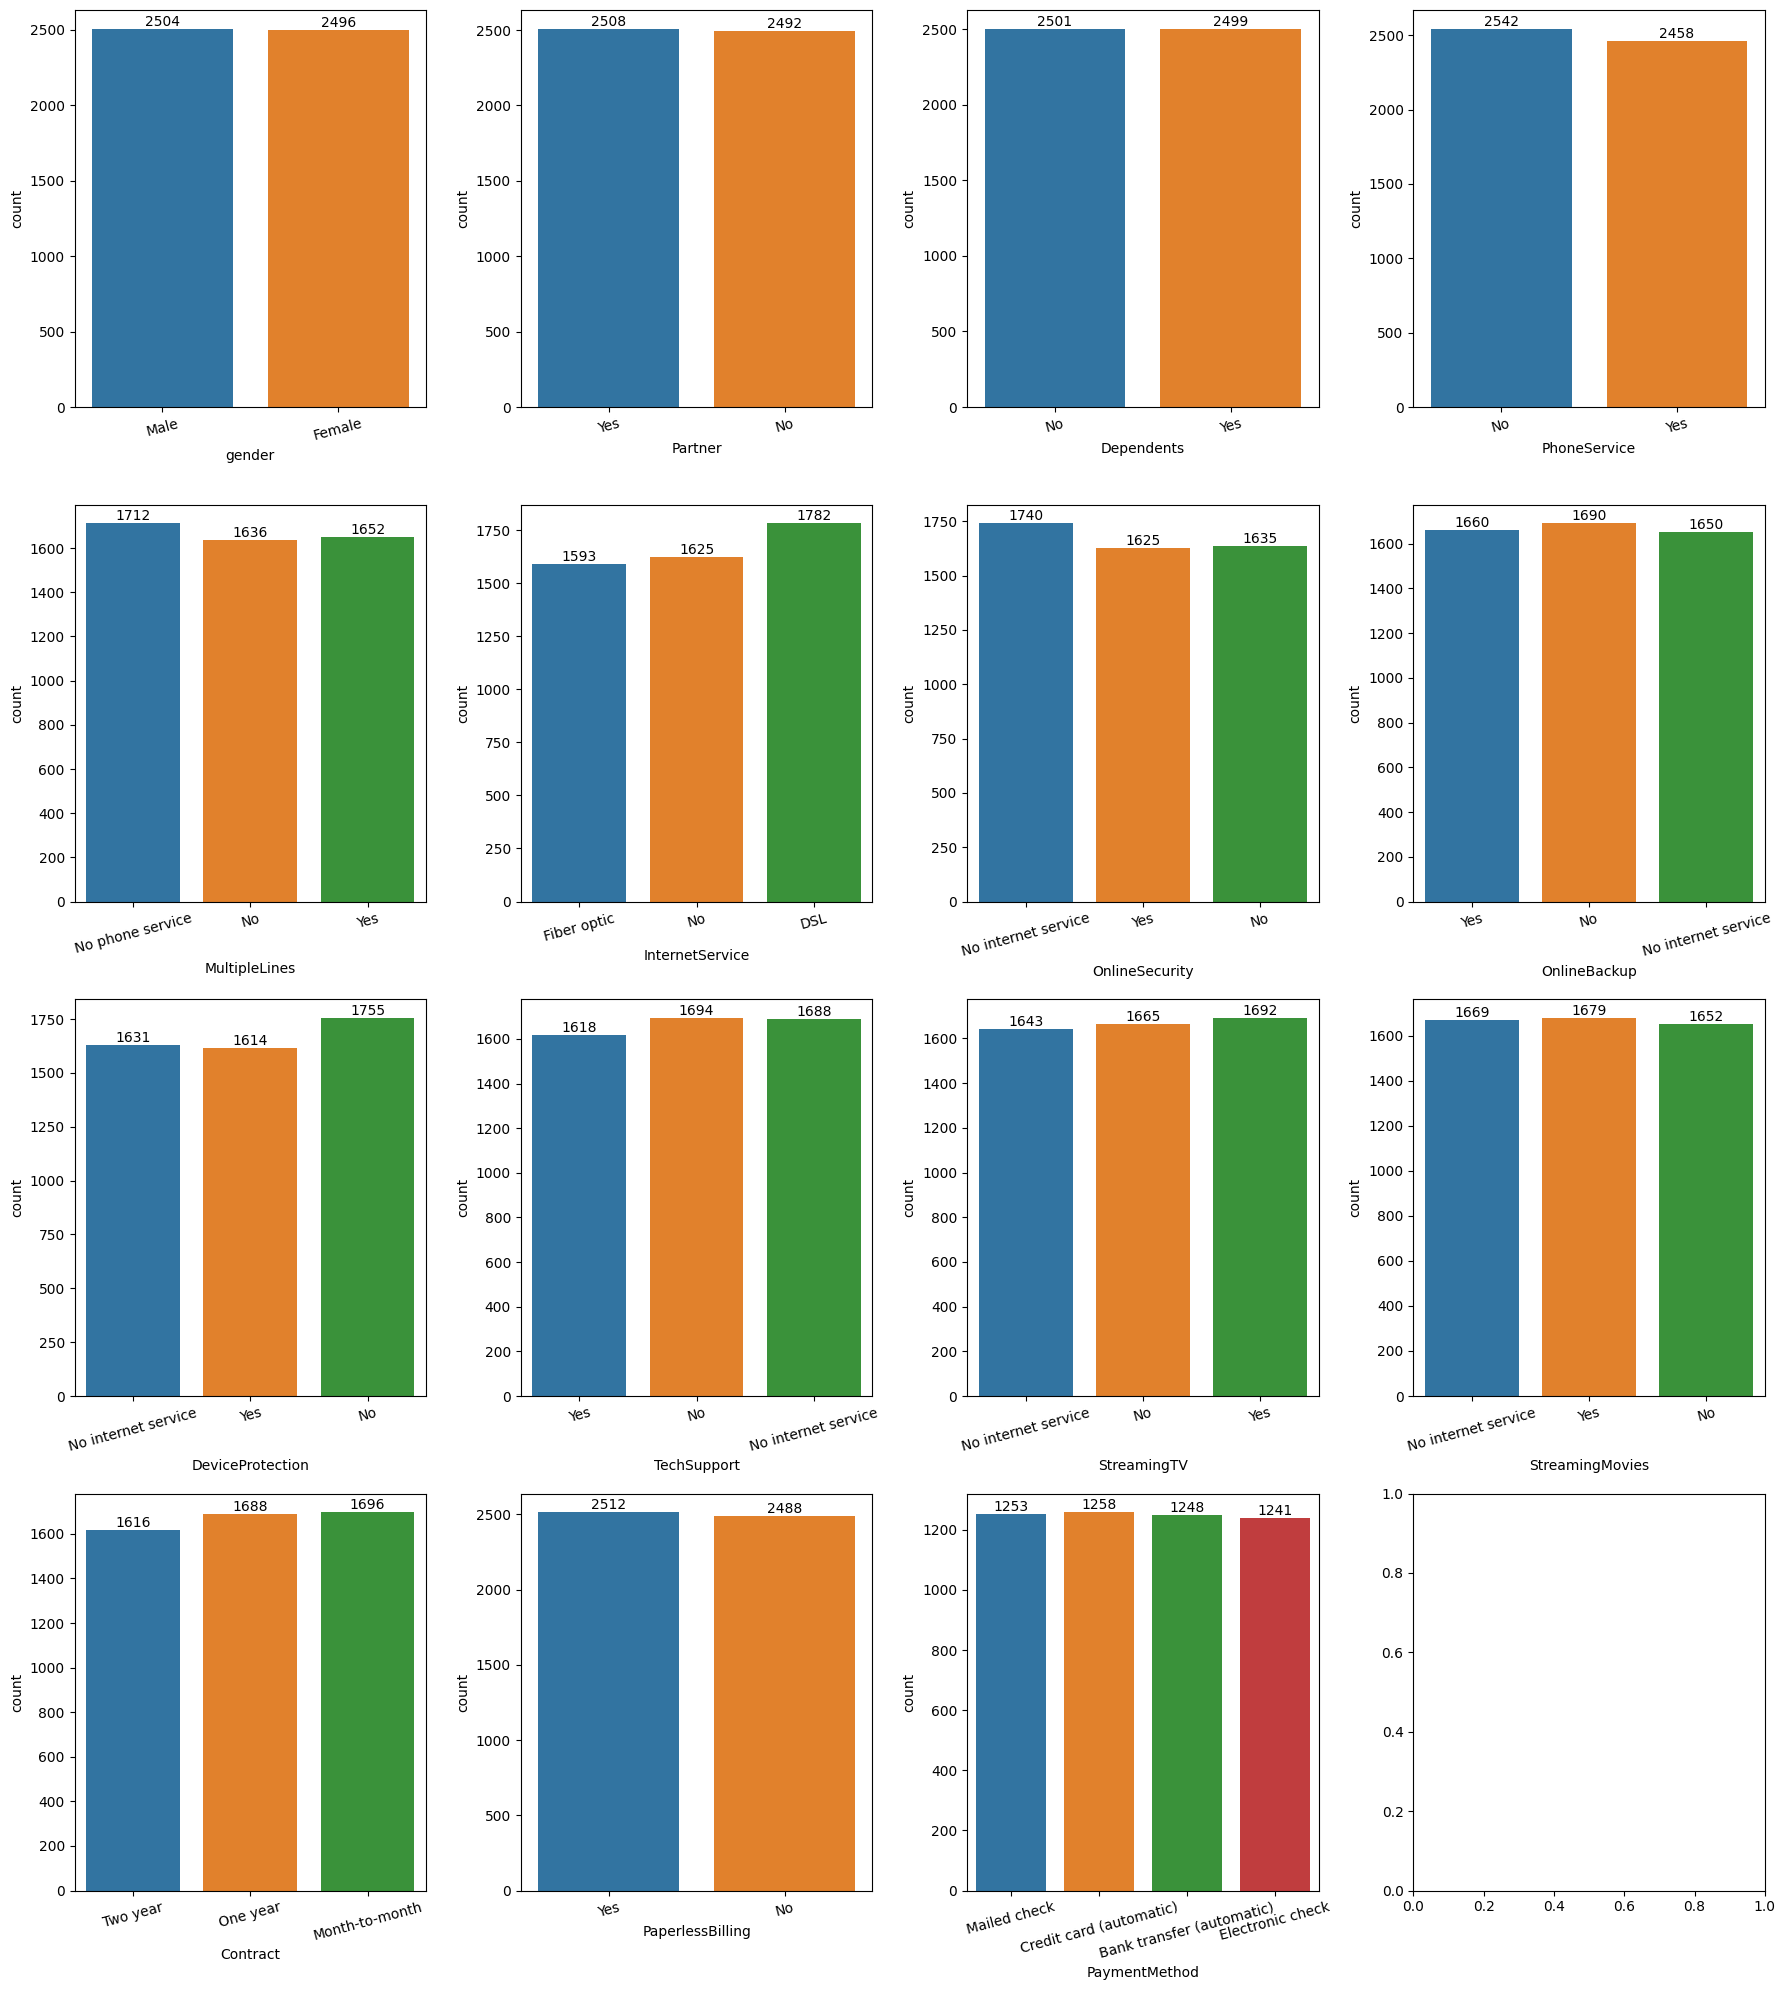

In [19]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(18, 20))

for ax, column in zip(axes.flatten(), categorical_cols):
    sns_fig = sns.countplot(data=df1, ax=ax, x=column, hue=column)
    sns_fig.tick_params(axis='x', rotation=15)
    for container in sns_fig.containers:
        sns_fig.bar_label(container)

plt.tight_layout()
plt.show()

### Data Cleaning

In [20]:
df1['Inconsistent_multiplelines'] = ((df1['PhoneService'] == "No") & (df1['MultipleLines'] == "Yes"))
df1['Inconsistent_multiplelines'].value_counts()

Inconsistent_multiplelines
False    4155
True      845
Name: count, dtype: int64

If a customer does not have **'PhoneService'**, then they cannot have **'MultipleLines'**.

So according to value counts of 'Inconsistent_multiplelines' 845 entries contains wrong data.

In [21]:
# Replace 'Yes' with 'No phone service' where PhoneService is 'No'
df1.loc[(df1['PhoneService'] == 'No') & (df1['MultipleLines'] == 'Yes'), 'MultipleLines'] = 'No phone service'

In [22]:
# drop 'Inconsistent_multiplelines' column 
df1.drop('Inconsistent_multiplelines', axis=1, inplace=True)

In [23]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5000 non-null   object 
 1   SeniorCitizen     5000 non-null   int64  
 2   Partner           5000 non-null   object 
 3   Dependents        5000 non-null   object 
 4   tenure            5000 non-null   int64  
 5   PhoneService      5000 non-null   object 
 6   MultipleLines     5000 non-null   object 
 7   InternetService   5000 non-null   object 
 8   OnlineSecurity    5000 non-null   object 
 9   OnlineBackup      5000 non-null   object 
 10  DeviceProtection  5000 non-null   object 
 11  TechSupport       5000 non-null   object 
 12  StreamingTV       5000 non-null   object 
 13  StreamingMovies   5000 non-null   object 
 14  Contract          5000 non-null   object 
 15  PaperlessBilling  5000 non-null   object 
 16  PaymentMethod     5000 non-null   object 


In [24]:
# Columns that depend on InternetService
internet_dependent_cols = ['OnlineSecurity', 'OnlineBackup', 'StreamingTV', 'StreamingMovies']

In [25]:
# Count 'Yes' values in those columns where InternetService is 'No' (invalid data)
total_records_to_update = 0
print("Records with invalid 'Yes' values when InternetService is 'No':\n")

for col in internet_dependent_cols:
    invalid_count = df1.loc[(df1['InternetService'] == 'No') & (df1[col] == 'Yes')].shape[0]
    print(f"- {invalid_count} records in column '{col}' need to be updated.")
    total_records_to_update += invalid_count

# Count records where all 4 columns have 'Yes' and InternetService is 'No' (common wrong data)
all_cols_invalid = df1.loc[
    (df1['InternetService'] == 'No') &
    (df1['OnlineSecurity'] == 'Yes') &
    (df1['OnlineBackup'] == 'Yes') &
    (df1['StreamingTV'] == 'Yes') &
    (df1['StreamingMovies'] == 'Yes')
].shape[0]

print(f"\n {all_cols_invalid} records have 'Yes' in **all** internet-dependent columns despite InternetService being 'No'.")
print(f"\n Total individual updates to be made: {total_records_to_update}\n")

Records with invalid 'Yes' values when InternetService is 'No':

- 550 records in column 'OnlineSecurity' need to be updated.
- 538 records in column 'OnlineBackup' need to be updated.
- 540 records in column 'StreamingTV' need to be updated.
- 528 records in column 'StreamingMovies' need to be updated.

 23 records have 'Yes' in **all** internet-dependent columns despite InternetService being 'No'.

 Total individual updates to be made: 2156



In [26]:
# Perform the updates
updated_record_count = 0
for col in internet_dependent_cols:
    mask = (df1['InternetService'] == 'No') & (df1[col] == 'Yes')
    updated_record_count += mask.sum()
    df1.loc[mask, col] = 'No internet service'

print(f"Total records successfully updated: {updated_record_count}")

Total records successfully updated: 2156


### EDA - Exploratory Data Analysis

#### Categorical Features vs Churn rate using barplot

In [27]:
# # Churn column to numeric for plotting (Yes → 1, No → 0)
# df1['Churn_numeric'] = df1['Churn'].map({'Yes': 1, 'No': 0})

# fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 10))

# for ax, column in zip(axes.flatten(), categorical_cols):
#     bar_fig = sns.barplot(data=df1, x=column, y='Churn_numeric', estimator='mean', width=0.2, palette='dark', ci=None, ax=ax)
#     bar_fig.tick_params(axis='x', rotation=70)

# plt.ylabel("Churn Rate (%)")
# plt.title(f"Churn Rate by {col}")
# plt.tight_layout()
# plt.show()

#### Numerical features vs Churn using kdeplot

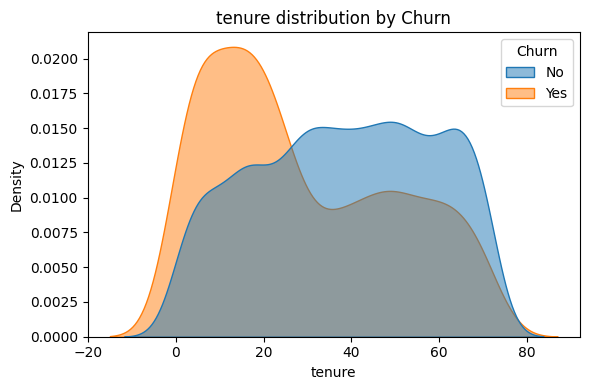

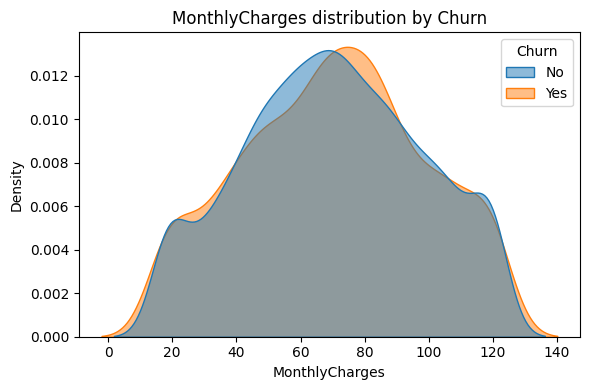

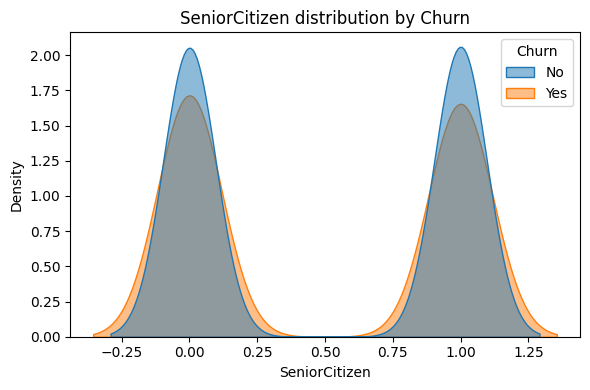

In [28]:
# Numerical Features → Distribution by Churn
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df1, x=col, hue='Churn', fill=True, common_norm=False, alpha=0.5)
    plt.title(f"{col} distribution by Churn")
    plt.tight_layout()
    plt.show()

##### Analysis: Numerical Features vs Churn

1. **Tenure**:
   - Customers with lower tenure (less than 30 months) are more likely to churn.
   - Customers with higher tenure (above 30 months) show a significantly lower churn rate.
   - **Insight**: Loyal customers tend to stay. Focus on improving the early customer experience to retain new users.

2. **Monthly Charges**:
   - Churned customers generally have higher monthly charges than those who stayed.
   - While distributions overlap, there's a slight shift toward higher charges for churners.
   - **Insight**: High-cost plans may lead to dissatisfaction or drop-off. Consider pricing optimization or bundling benefits.

3. **Senior Citizen**:
   - The churn distribution among senior citizens and non-senior customers is almost equal, indicating that senior citizen status does not have a strong impact on churn. The company may not need to design separate retention strategies based solely on age.


In [29]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5000 non-null   object 
 1   SeniorCitizen     5000 non-null   int64  
 2   Partner           5000 non-null   object 
 3   Dependents        5000 non-null   object 
 4   tenure            5000 non-null   int64  
 5   PhoneService      5000 non-null   object 
 6   MultipleLines     5000 non-null   object 
 7   InternetService   5000 non-null   object 
 8   OnlineSecurity    5000 non-null   object 
 9   OnlineBackup      5000 non-null   object 
 10  DeviceProtection  5000 non-null   object 
 11  TechSupport       5000 non-null   object 
 12  StreamingTV       5000 non-null   object 
 13  StreamingMovies   5000 non-null   object 
 14  Contract          5000 non-null   object 
 15  PaperlessBilling  5000 non-null   object 
 16  PaymentMethod     5000 non-null   object 


In [30]:
# partner, contract vs churn
# dependents , internetservice, streamingtv-movies, phoneservice, multiplelines vs churn
# monthlycharges vs churn
# deviceprotection, techsupport vs churn
# seniorcitizen vs churn

In [31]:
df1['Churn_numeric'] = df1['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

#### Partner & Contract Type vs Churn

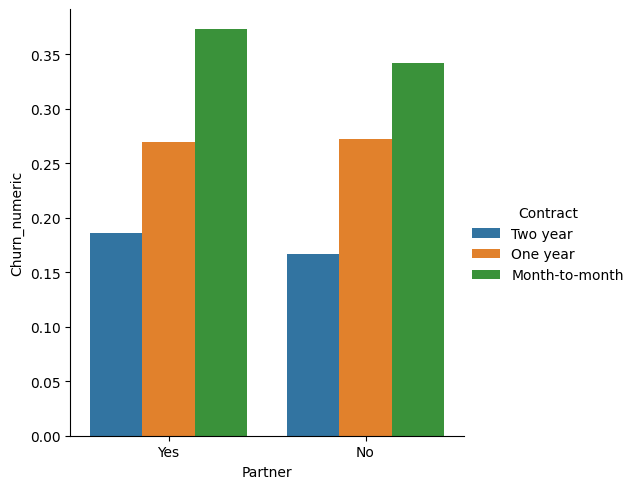

In [32]:
sns.catplot(data=df1, x='Partner', y='Churn_numeric', hue='Contract', kind='bar', ci=None)

Month-to-month contracts have the highest churn, especially for customers with a partner.

Churn is lowest for Two-year contracts, and having a partner slightly reduces churn across all contract types.

#### DeviceProtection & TechSupport Type vs Churn

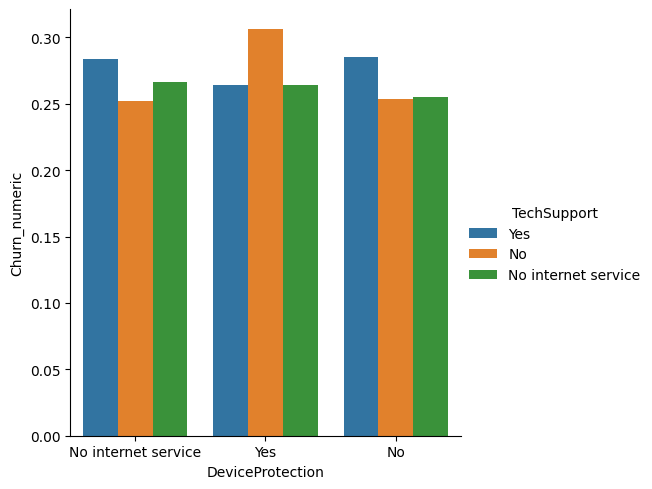

In [33]:
sns.catplot(data=df1, x='DeviceProtection', y='Churn_numeric', hue='TechSupport', kind='bar', ci=None)

Churn is highest when TechSupport is 'No', especially for customers who also have Device Protection.

Having TechSupport helps reduce churn slightly, regardless of whether Device Protection is present or not.

#### MonthlyCharges vs Churn

Text(0.5, 1.0, 'Monthly Charges vs Churn')

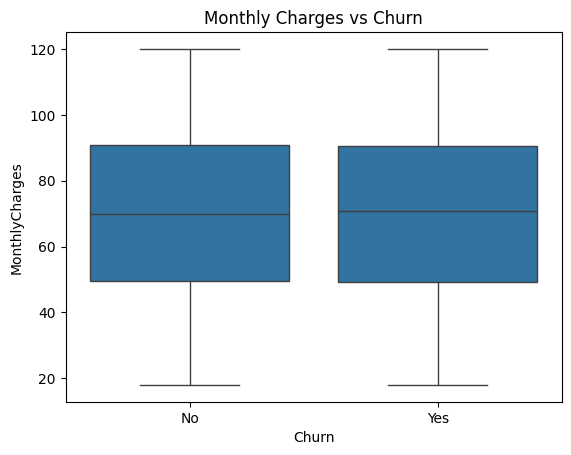

In [34]:
sns.boxplot(data=df1, x='Churn', y='MonthlyCharges')
plt.title('Monthly Charges vs Churn')

#### SeniorCitizen vs Churn

Text(0.5, 1.0, 'SeniorCitizen vs Churn')

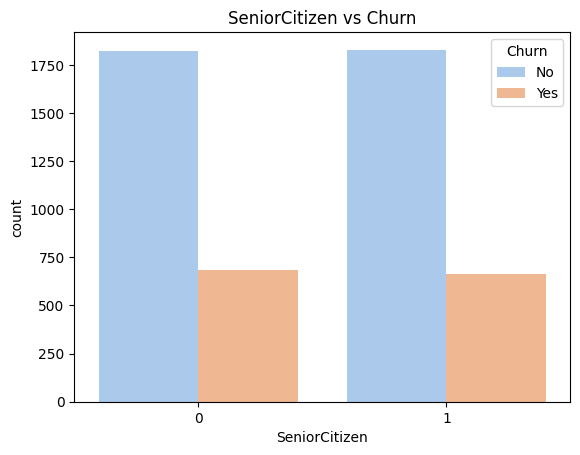

In [35]:
sns.countplot(data=df1, x='SeniorCitizen', hue='Churn', palette='pastel', dodge=True)
plt.title('SeniorCitizen vs Churn')

#### Contract × Internet Service vs Churn

<Axes: xlabel='InternetService', ylabel='Contract'>

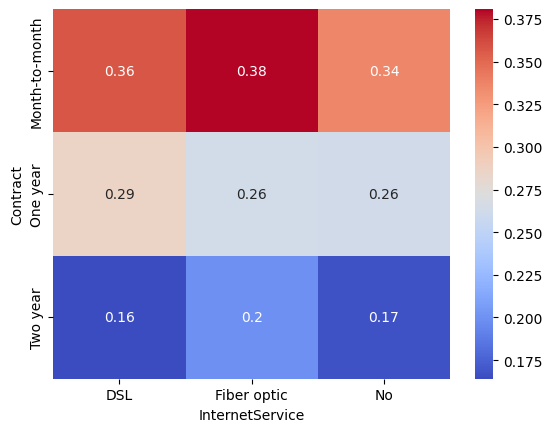

In [36]:
pivot = df1.pivot_table(values='Churn_numeric', index='Contract', columns='InternetService')
sns.heatmap(pivot, annot=True, cmap='coolwarm')

#### Total Services vs Churn

<Axes: xlabel='TotalServices', ylabel='Churn_numeric'>

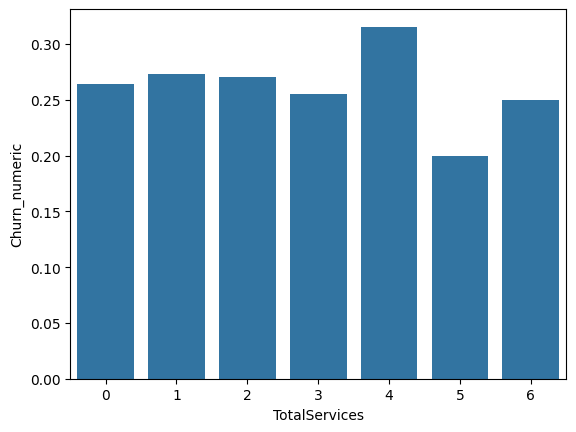

In [37]:
services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df1['TotalServices'] = df1[services].apply(lambda x: (x == 'Yes').sum(), axis=1)
sns.barplot(data=df1, x='TotalServices', y='Churn_numeric', ci=None)